<a href="https://colab.research.google.com/github/fab0822/diabets/blob/master/signate_diabetes_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import csv
import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import (roc_curve, auc)
from sklearn.model_selection import GridSearchCV


from google.colab import drive
from google.colab import files

In [ ]:
SEED = 2021
NUM_COL = 8

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train (1).csv')
test = pd.read_csv('/content/drive/My Drive/test (1).csv')

sub = pd.read_csv('/content/drive/My Drive/sample_submit (1).csv', header=None)

In [ ]:
sub

,0,1
0,398,0
1,3833,0
2,4836,0
3,4572,0
4,636,0
...,...,...
1995,3138,0
1996,191,0
1997,3294,0
1998,3073,0


In [ ]:
train.shape

(3000, 10)

In [ ]:
test.shape

(2000, 9)

In [ ]:
sub.shape

(2000, 2)

In [ ]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.262073,0.400476,28.932000,0.239000
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,7.568025,0.274666,8.469078,0.426544
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000775,0.145844,21.000000,0.000000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000


In [ ]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

In [ ]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,9,125,74,0,0,28.536910,0.444902,45,1
1,4,109,80,0,0,28.047673,0.238243,22,0
2,4,88,78,39,0,52.371341,0.279471,26,0
3,9,125,74,0,0,40.062688,0.203922,45,0
4,5,107,78,44,284,52.935068,0.284959,45,1


In [ ]:
y_train = train['Outcome'].reset_index(drop=True)
train_features = train.drop(['Outcome'], axis=1)
test_features = test

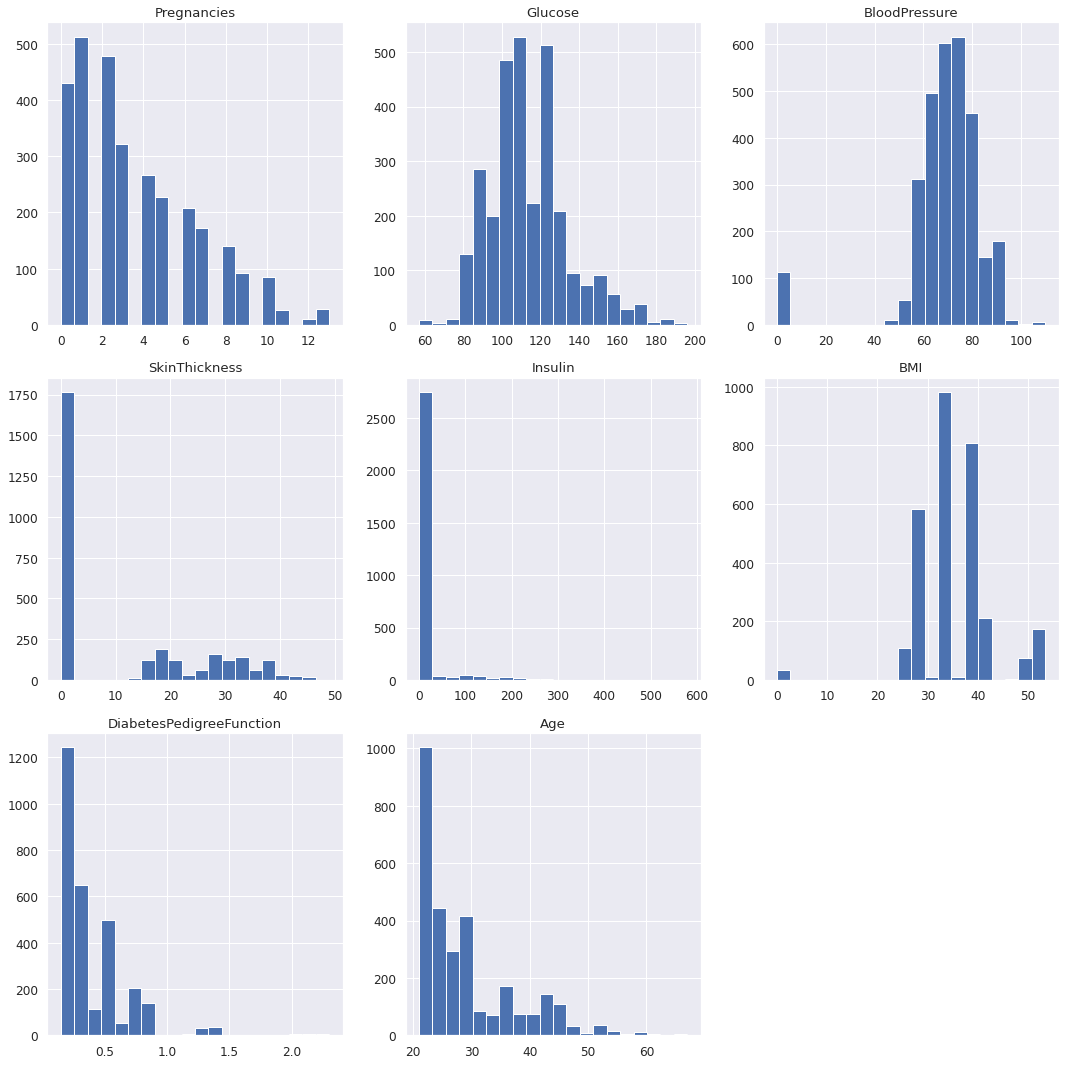

In [ ]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 15
train_features.hist(bins=20)
plt.tight_layout()

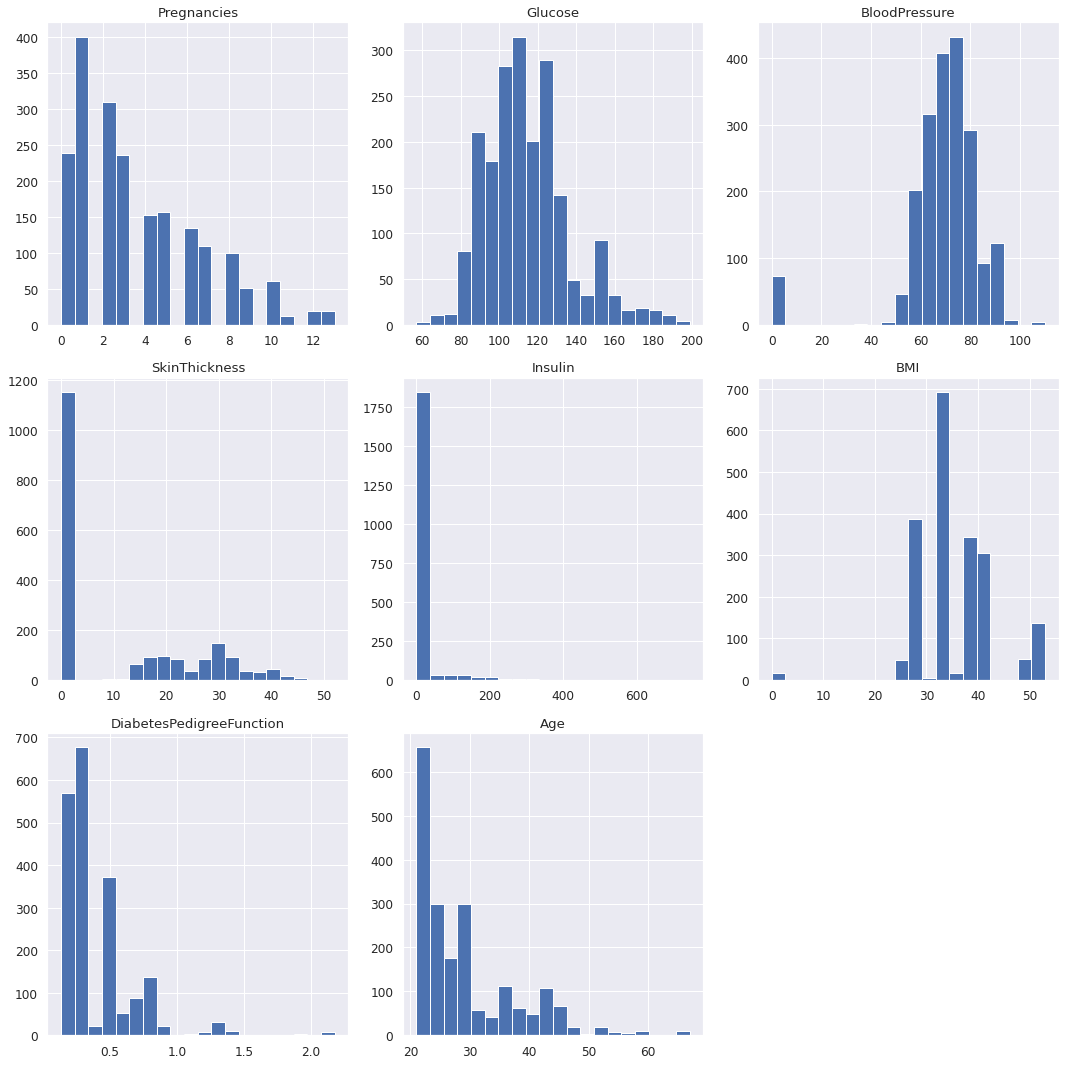

In [ ]:
rcParams['figure.figsize'] = 15, 15
test_features.hist(bins=20)
plt.tight_layout()

In [ ]:
#p01 = train_features.quantile(0.01)
#p99 = train_features.quantile(0.99)

#print(p01)
#print(p99)

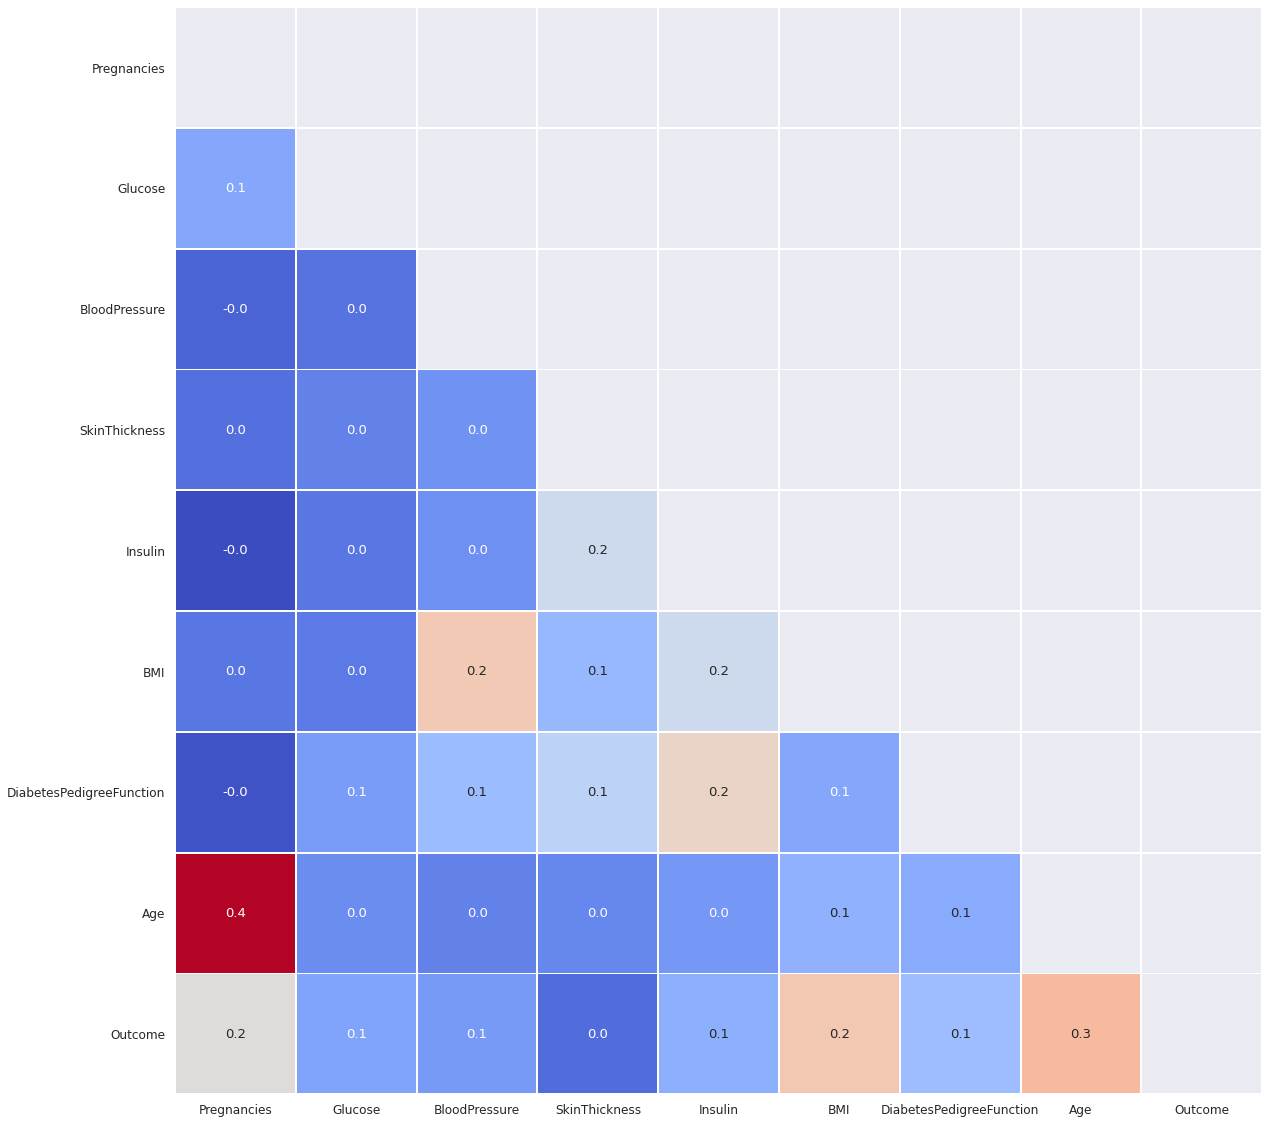

In [ ]:
# Display numerical correlations (pearson) between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

In [ ]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(5000, 8)


In [ ]:
features.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [ ]:
features.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [ ]:
features.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1921,1,135,46,19,0,33.518513,0.203752,22
3733,3,151,76,19,180,39.610066,0.219305,28
1486,9,125,74,0,0,33.254436,0.237442,38
257,9,125,70,0,0,27.723496,0.198672,45
4701,5,126,78,0,0,33.109448,0.235401,26


In [ ]:
features.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.567800,113.957600,68.752800,11.180000,11.741600,35.347125,0.400987,28.989400
std,3.040535,21.333505,16.268147,14.232446,47.022061,7.496245,0.271619,8.509722
min,0.000000,57.000000,0.000000,0.000000,0.000000,0.000775,0.137377,21.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,32.453978,0.232290,22.000000
50%,3.000000,111.000000,70.000000,0.000000,0.000000,33.828671,0.269691,26.000000
75%,6.000000,125.000000,78.000000,24.000000,0.000000,39.627290,0.506604,33.000000
max,13.000000,199.000000,110.000000,52.000000,744.000000,53.400629,2.302072,67.000000


In [ ]:
# Separating train and test set.

X_train = features.iloc[:len(y_train), :]
X_test = features.iloc[len(train):, :]

In [ ]:
#cross validation
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_id, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_valid = X_train.loc[val_index, :]
    y_tr = y_train[train_index]
    y_valid = y_train[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, )

    params = {
        'objective': 'binary'
    }

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=10
    )

    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.416068	valid_1's binary_logloss: 0.410129
[20]	training's binary_logloss: 0.357641	valid_1's binary_logloss: 0.351842
[30]	training's binary_logloss: 0.316332	valid_1's binary_logloss: 0.309169
[40]	training's binary_logloss: 0.287325	valid_1's binary_logloss: 0.279638
[50]	training's binary_logloss: 0.263562	valid_1's binary_logloss: 0.255422
[60]	training's binary_logloss: 0.242486	valid_1's binary_logloss: 0.233841
[70]	training's binary_logloss: 0.224709	valid_1's binary_logloss: 0.213868
[80]	training's binary_logloss: 0.207444	valid_1's binary_logloss: 0.19748
[90]	training's binary_logloss: 0.194221	valid_1's binary_logloss: 0.184844
[100]	training's binary_logloss: 0.182026	valid_1's binary_logloss: 0.172013
[110]	training's binary_logloss: 0.169677	valid_1's binary_logloss: 0.158845
[120]	training's binary_logloss: 0.158913	valid_1's binary_logloss: 0.148613
[130]	training's binary_

In [ ]:
print(oof_train[:10])

scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.0034795]
===CV scores===
[0.0010312484320296005, 0.0011023616756716966, 0.001143027831142683, 0.0012290691120996429, 0.0011789240588205303]
0.0011369262219528306


In [ ]:
y_pred_oof = (oof_train > 0.5).astype(int)
accuracy_score(y_train, y_pred_oof)

0.809

In [ ]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.5).astype(int)
y_sub[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
sub[1] = y_sub
sub.to_csv('submission_lgbm_StrKfold.csv', index=False, header=False)

sub.head()

,0,1
0,398,0
1,3833,0
2,4836,0
3,4572,1
4,636,0


In [ ]:
files.download('submission_lgbm_StrKfold.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>